![BTS](https://github.com/vfp1/bts-dsf-2020/raw/main/Logo-BTS.jpg)



**Resources:**
* Sklearn documentation

# Part 1: Logistic Regression 

We are given a dataset of  direct marketing campaigns of a credit institution. **Our goal is to implement a model to predict whether the client will subscribe to a term deposit.**

**When working on the assignment there could be multiple ways to explore data or implement specific analysis. Choose that one you retain more appropriate but always justify every choice you make (e.g., why you choose some variables), comment your code, describe the plots and results you obtain.**


### Enjoy!

DATASET DESCRIPTION

- age (numeric)
- job : type of job 
- marital : marital status
- education 
- default: has credit in default? 
- housing: has housing loan? 
- loan: has personal loan? 
- contact: contact communication type 
- month: last contact month of year 
- day_of_week: last contact day of the week 
- duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y=’no’). The duration is not known before a call is performed, also, after the end of the call, y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model
- campaign: number of contacts performed during this campaign and for this client 
- pdays: number of days that passed by after the client was last contacted from a previous campaign (999 means client was not previously contacted)
- previous: number of contacts performed before this campaign and for this client (numeric)
- poutcome: outcome of the previous marketing campaign 
- emp.var.rate: employment variation rate 
- cons.price.idx: consumer price index 
- cons.conf.idx: consumer confidence index 
- euribor3m: euribor 3 month rate 
- nr.employed: number of employees 
- y — Target variable: has the client subscribed a term deposit? 

##### Import libraries

In [11]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=18)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [5]:
data = pd.read_csv('banking.csv')
data.head(3)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1


In [3]:
data.shape

(41188, 21)

## EDA and Feature Engineering 

An important requirement for Logistic Regression to function properly is Feature Engineering as it helps to identify independent variables. Without proper identification of independent variables Logistic Regression fails to perform correctly.

One disadvantage of logistic regression is that it doesn’t handle large number of categorical variables well.

```education``` column has many categories, try to reduce the categories for a better modelling. The education column has the following categories.


In [ ]:
data.education.unique()

array(['basic.4y', 'unknown', 'university.degree', 'high.school',
       'basic.9y', 'professional.course', 'basic.6y', 'illiterate'],
      dtype=object)

We will group all ```basic.XX``` in a unique value ```basic```

In [6]:
data['education'] = data['education'].replace(['basic.4y', 'basic.9y', 'basic.6y'], 'basic')

In [7]:
print(data['education'])

0                      basic
1                    unknown
2          university.degree
3                high.school
4                      basic
                ...         
41183            high.school
41184                  basic
41185      university.degree
41186    professional.course
41187            high.school
Name: education, Length: 41188, dtype: object


In [8]:
print(data['education'].unique())

['basic' 'unknown' 'university.degree' 'high.school' 'professional.course'
 'illiterate']


##### Analyse the distribution of the target variable

In [9]:
print(data.columns)

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'y'],
      dtype='object')


C:\Users\charl\AppData\Local\Temp\ipykernel_13544\4226699903.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='y', data=data, palette=['steelblue', 'sandybrown'])


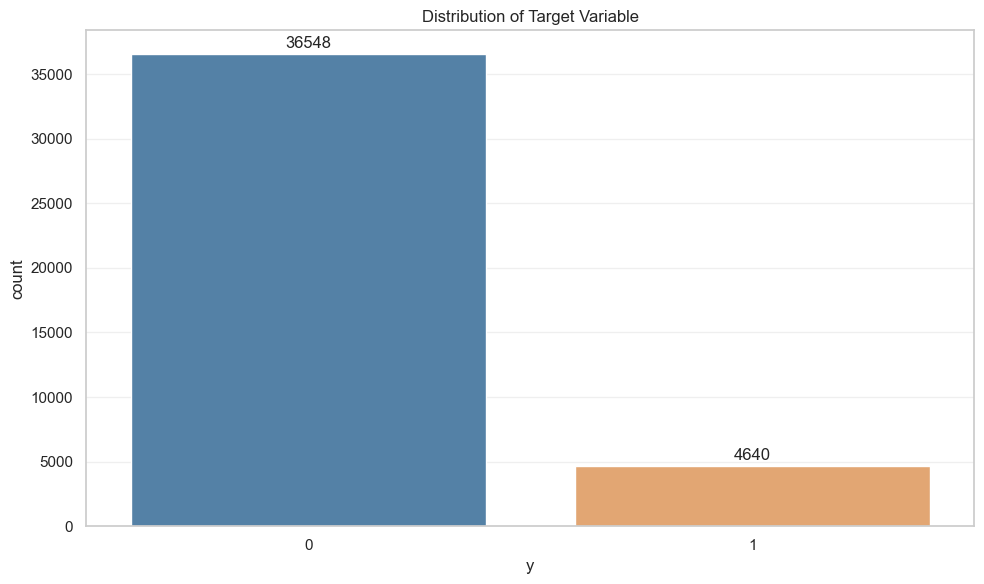

Target variable distribution:
y
0    36548
1     4640
Name: count, dtype: int64


In [12]:
y_counts = data['y'].value_counts()
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='y', data=data, palette=['steelblue', 'sandybrown'])
for i, count in enumerate(y_counts):
    plt.text(i, count + 500, f'{count}', ha='center', fontsize=12)

plt.title('Distribution of Target Variable')
plt.ylabel('count')
plt.xlabel('y')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print the distribution
print("Target variable distribution:")
print(y_counts)


In [13]:
y_counts = data['y'].value_counts().reset_index()
y_counts.columns = ['y', 'count']
y_counts['perc'] = y_counts['count'] / y_counts['count'].sum() * 100
y_counts['perc'] = y_counts['perc'].round(2)
print(y_counts)

   y  count   perc
0  0  36548  88.73
1  1   4640  11.27


##### What can we observe about the distribution of the target variable

The target variable is highly imbalanced with class 0 (88.73%) being much more prevalent than class 1 (11.27%).

This imbalance will need to be addressed when building the logistic regression model

##### Observe how the different numeric variables behave for the 2 classes

In [ ]:
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'y' in numeric_columns:
    numeric_columns.remove('y')

class_means = data.groupby('y')[numeric_columns].mean()
display(class_means)

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


Observations:
- Call duration shows the strongest signal (553s for subscribers vs 221s for non-subscribers),
- Previous contacts and employment rate reveal important patterns: subscribers had more prior contacts (0.49 vs 0.13) and converted during periods of negative employment variation (-1.23 vs 0.25).
- Economic indicators matter: subscribers converted when Euribor3m rates were lower (2.12 vs 3.81)

##### Analyse other variables - Make some plots and discuss them

- **Job title**

<Figure size 1200x600 with 0 Axes>

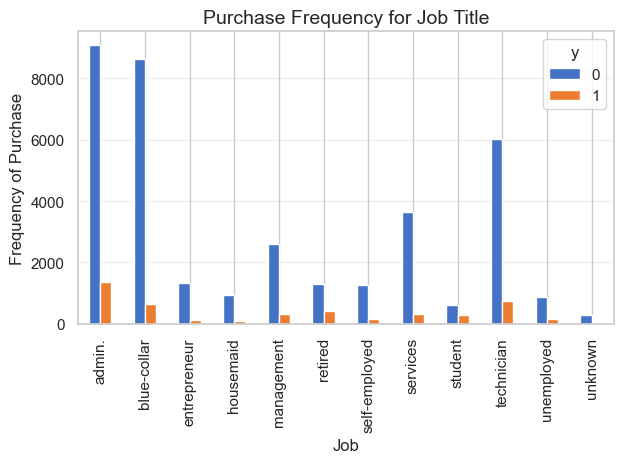

In [20]:
job_counts = pd.crosstab(data['job'], data['y'])
plt.figure(figsize=(12, 6))
job_counts.plot(kind='bar', color=['#4472C4', '#ED7D31'])

plt.title('Purchase Frequency for Job Title', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)


plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

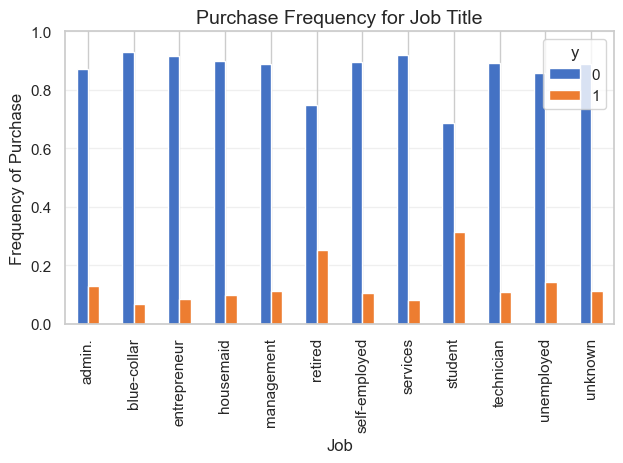

In [21]:
job_counts = pd.crosstab(data['job'], data['y'])
job_proportions = job_counts.div(job_counts.sum(axis=1), axis=0)
job_order = ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 
             'retired', 'self-employed', 'services', 'student', 'technician', 
             'unemployed', 'unknown']
job_proportions = job_proportions.reindex(job_order)
plt.figure(figsize=(12, 6))
job_proportions.plot(kind='bar', color=['#4472C4', '#ED7D31'])
plt.title('Purchase Frequency for Job Title', fontsize=14)
plt.xlabel('Job', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)

plt.ylim(0, 1)
plt.tight_layout()
plt.show()

- Comment the plots

Students and retirees show highest conversion rates (~30% and ~25% respectively) i am unable to explain the reasons, maybe that they have more time ??

workers (Blue-collar) have the lowest conversion proportion (~7%), despite being one of the largest group, that is the proof that banks are giving less credits to low income

- **Marital status**

<Figure size 1000x600 with 0 Axes>

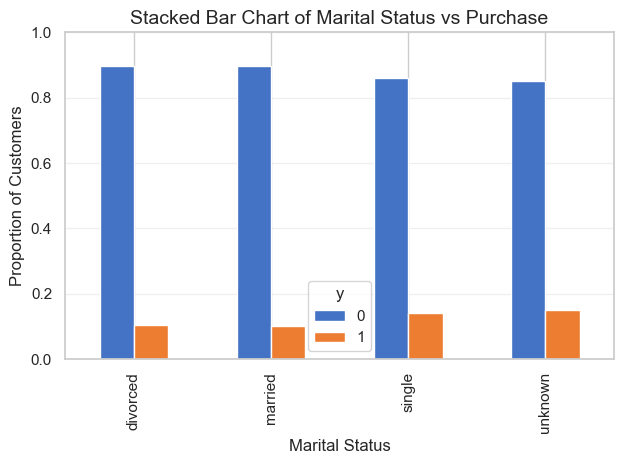

In [22]:
marital_counts = pd.crosstab(data['marital'], data['y'])

# Normalize the data to show proportions within each marital status category
marital_proportions = marital_counts.div(marital_counts.sum(axis=1), axis=0)

marital_order = ['divorced', 'married', 'single', 'unknown']
marital_proportions = marital_proportions.reindex(marital_order)
plt.figure(figsize=(10, 6))
marital_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])
plt.title('Stacked Bar Chart of Marital Status vs Purchase', fontsize=14)
plt.xlabel('Marital Status', fontsize=12)
plt.ylabel('Proportion of Customers', fontsize=12)

plt.grid(axis='y', linestyle='-', alpha=0.3)

plt.ylim(0, 1)
plt.tight_layout()
plt.show()


 Overall conversion gap is narrow across marital categories, with only ~5% difference between highest and lowest performing segments, making marital status a less decisive targeting factor than job category.

- **Education**

<Figure size 1000x600 with 0 Axes>

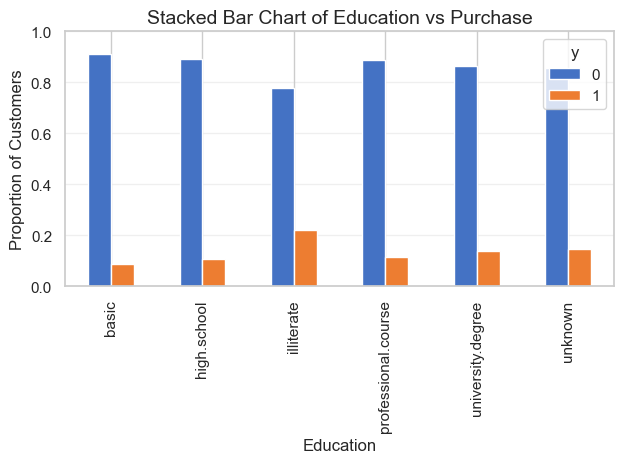

In [24]:
education_counts = pd.crosstab(data['education'], data['y'])
education_proportions = education_counts.div(education_counts.sum(axis=1), axis=0)

education_order = ['basic', 'high.school', 'illiterate', 'professional.course', 'university.degree', 'unknown']
education_proportions = education_proportions.reindex(education_order)

plt.figure(figsize=(10, 6))
education_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])

plt.title('Stacked Bar Chart of Education vs Purchase', fontsize=14)
plt.xlabel('Education', fontsize=12)
plt.ylabel('Proportion of Customers', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


 Illiterate customers have significantly higher conversion rates (~22%) compared to all other education segments, a surprising finding that warrants further investigation. 

 Education level reveals a substantial targeting opportunity with over 2x difference between highest and lowest converting segments, making it potentially more actionable than marital status for campaign optimization.

- **Day of Week**

<Figure size 1000x600 with 0 Axes>

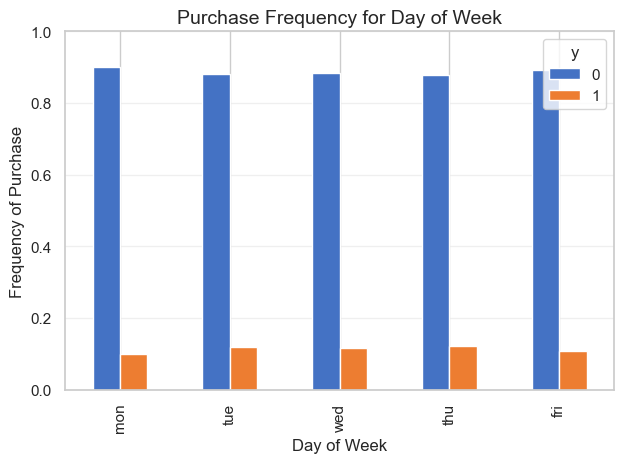

In [27]:
day_counts = pd.crosstab(data['day_of_week'], data['y'])
day_proportions = day_counts.div(day_counts.sum(axis=1), axis=0)

day_order = ['mon', 'tue', 'wed', 'thu', 'fri']
day_proportions = day_proportions.reindex(day_order)

plt.figure(figsize=(10, 6))
day_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])

plt.title('Purchase Frequency for Day of Week', fontsize=14)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Wednesday perform the worst with the lowest conversion rate (~10%), suggesting a potential minor optimization opportunity by shifting some Wednesday calls to other days.
thurday shows slightly higher conversion rate

- **Month**

<Figure size 1200x600 with 0 Axes>

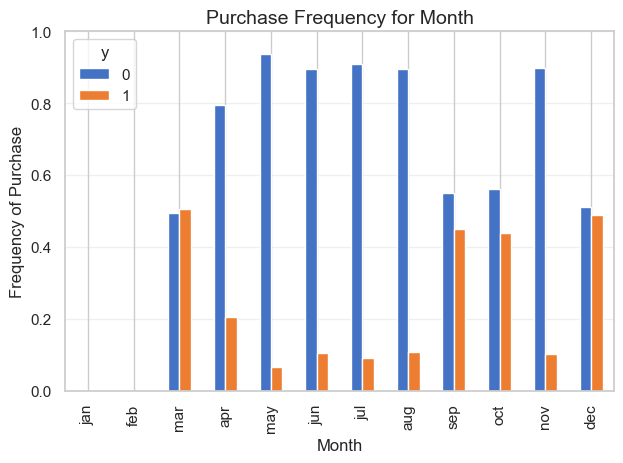

In [30]:
month_counts = pd.crosstab(data['month'], data['y'])
month_proportions = month_counts.div(month_counts.sum(axis=1), axis=0)

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_proportions = month_proportions.reindex(month_order)

plt.figure(figsize=(12, 6))
month_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])

plt.title('Purchase Frequency for Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

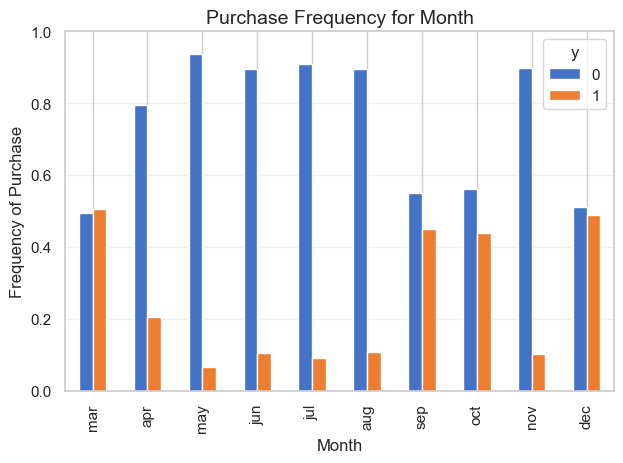

In [31]:
month_counts = pd.crosstab(data['month'], data['y'])
month_proportions = month_counts.div(month_counts.sum(axis=1), axis=0)

month_order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
month_proportions = month_proportions.reindex(month_order)

plt.figure(figsize=(12, 6))
month_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])

plt.title('Purchase Frequency for Month', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

what happened with january and february ? 

 Dramatic seasonal variation in campaign effectiveness with December and March showing exceptionally high conversion rates (50%), while May shows the lowest (5-7%).

- **poutcome**

<Figure size 1000x600 with 0 Axes>

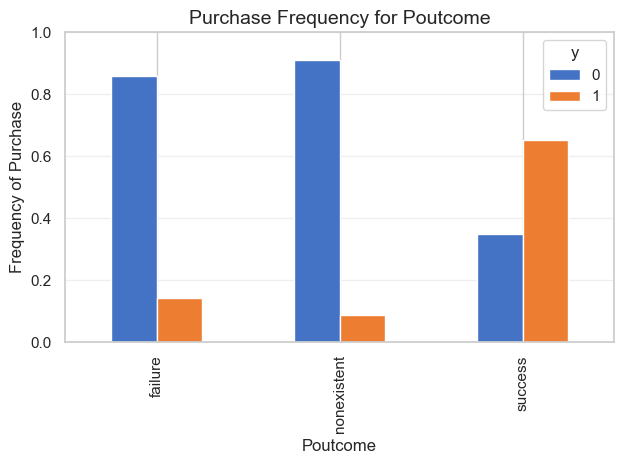

In [32]:
poutcome_counts = pd.crosstab(data['poutcome'], data['y'])
poutcome_proportions = poutcome_counts.div(poutcome_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10, 6))
poutcome_proportions.plot(kind='bar', stacked=False, color=['#4472C4', '#ED7D31'])

plt.title('Purchase Frequency for Poutcome', fontsize=14)
plt.xlabel('Poutcome', fontsize=12)
plt.ylabel('Frequency of Purchase', fontsize=12)
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Prior success is the strongest predictor of future success with ~65% conversion rate for customers who previously subscribed to a term deposit, compared to only 9-14% for other categories.
they should prioritize re-engagement with previously successful customers before attempting to convert new prospects or previous failures.

### Create dummy variables

In [12]:
data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


In [13]:
data.isnull().sum()


age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [14]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                        'contact', 'month', 'day_of_week', 'poutcome']
# One-hot encoding for categorical features

In [16]:

df_encoded = pd.get_dummies(data, columns=categorical_features, drop_first=True)


In [18]:
df_encoded.columns


Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'marital_unknown',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_unknown',
       'default_yes', 'housing_unknown', 'housing_yes', 'loan_unknown',
       'loan_yes', 'contact_telephone', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'day_of_week_mon', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_nonexistent', 'poutc

### Implement the Logistic Regression Model

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


##### Prepare the dataset for training

In [19]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [22]:

model = LogisticRegression(max_iter=1000)


In [23]:

model.fit(X_train, y_train)


c:\bts\CDA\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

##### Compute predictions and accuracy using the accuracy score provided by the sklearn library

In [25]:
y_pred = model.predict(X_test)

In [26]:

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9131666262037711

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10981
           1       0.67      0.43      0.52      1376

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357


Confusion Matrix:
[[10697   284]
 [  789   587]]


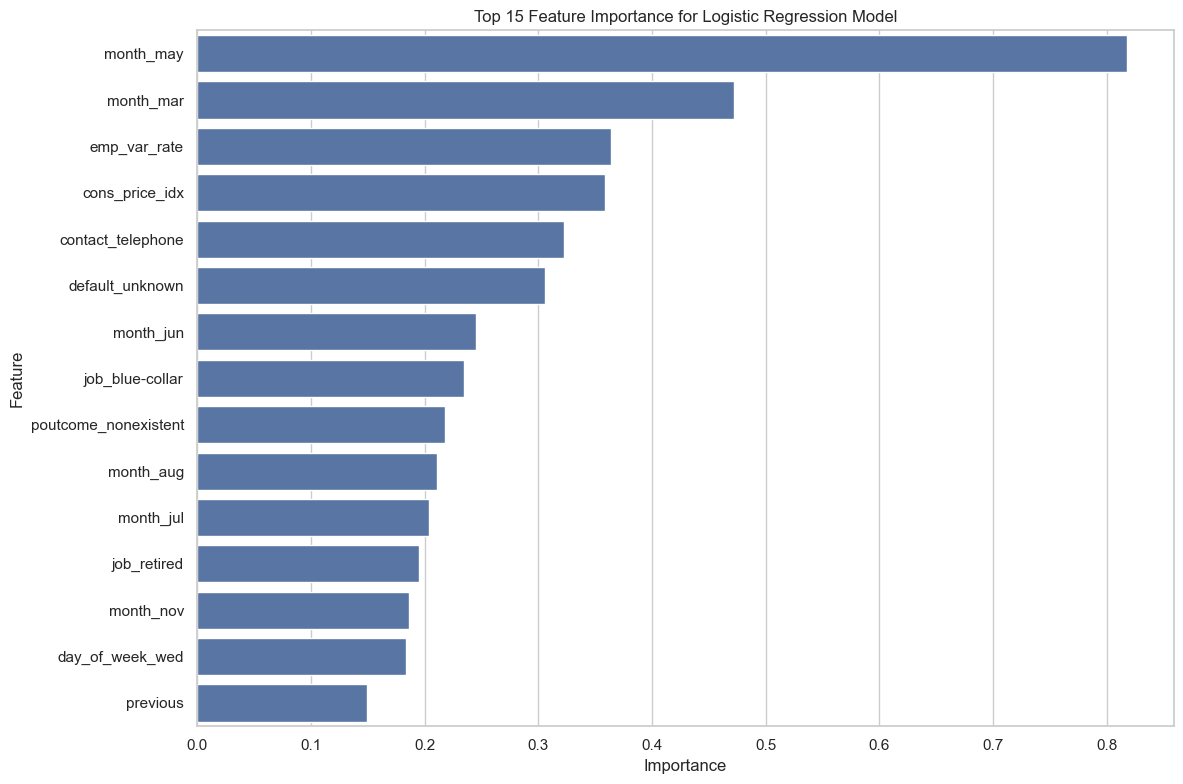

In [28]:
coefficients = model.coef_[0]
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': np.abs(coefficients)})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Top 15 Feature Importance for Logistic Regression Model')
plt.tight_layout()
plt.show()


##### An accuracy of **91%** looks quite a good result, but have a look more in detail observing the confusion matrix and other metrics you consider interesting.


##### EXPLAIN WHY ACCURACY IS NOT ENOUGH TO EVALUATE THE PERFORMANCE OF A CLASSIFIER AND WHY IT MIGHT FAIL IN CASE OF IMBALANCED DATASET


**in scenarios like deposit subscription prediction, missing potential subscribers (false negatives) might be costlier than incorrectly identifying non-subscribers (false positives).


our problem is that with imbalanced classes, a model can achieve high accuracy by simply predicting the majority class for all instances.

the biggest problem i have is if 90% of data belongs to class 0, a model that always predicts 0 would achieve 90% accuracy without learning anything.**

The confusion matrics gives an interesting overview of how well a model is doing and it is a great starting point for any classification model evaluation.

![](https://skappal7.files.wordpress.com/2018/08/confusion-matrix.jpg?w=748)

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)


In [30]:
print (conf_matrix)

[[10697   284]
 [  789   587]]


**Is our model obtaining good results or is it failing in some specific case?**

This confusion matrix clearly shows we have an imbalanced dataset problem, and the model's performance isn't as good as the 91% accuracy suggested.

Despite the high accuracy, this model fails to effectively identify many potential subscribers (high false negative rate). For a marketing campaign targeting potential subscribers, this is problematic as we're missing more than half of the opportunities.




##### Compute other metrics using classification report

In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     10981
           1       0.67      0.43      0.52      1376

    accuracy                           0.91     12357
   macro avg       0.80      0.70      0.74     12357
weighted avg       0.90      0.91      0.90     12357



In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score 

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.6739
Recall: 0.4266
F1 Score: 0.5225


## Imbalanced Classes

Imbalanced data typically refers to a problem with classification problems where the classes are not represented equally.


##### Explain why imbalanced data can be a problem 

it create some biais, we experienced that in our final project (emotion classification). If the data is imbalanced, the model can become racist



##### SMOTE

During the exploratory data analysis we have seen that we have **Imbalanced Classes**, i.e.,the percentage of negative examples is much higher with respect to the percentage of positiv examples. Indeed, observing the confusion matrix we saw that the implmented model face some problem in predict the positive examples (if a client will subscribe a term deposit).


To face this problem we will apply an over-sampling technique trying to balance our dataset generating **Synthetic Samples:** it consists in creating new synthetic points from the minority class to increase its cardinality.

we will use the **SMOTE** Algorithm [see here for more details](https://arxiv.org/pdf/1106.1813.pdf).

In order to apply SMOTE **install the imblearn python library** (if you already have it you do not need to reinstall):

[Follow this instructions](https://imbalanced-learn.readthedocs.io/en/stable/install.html)


### Now implent again the model following all the steps

Prepare the data

In [45]:
X = data.loc[:, data.columns != 'y']
y = data.loc[:, data.columns == 'y']

# Convert y to a 1D array for compatibility with SMOTE
y = y.values.ravel()

##### Apply SMOTE to generate synthetic data

In [50]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()


if len(categorical_cols) > 0:
    # Apply OneHotEncoder to categorical columns
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    
    X_train_encoded = encoder.fit_transform(X_train[categorical_cols])
    X_test_encoded = encoder.transform(X_test[categorical_cols])
    encoded_feature_names = encoder.get_feature_names_out(categorical_cols)
    X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
    X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)
    
    X_train = pd.concat([X_train[numerical_cols], X_train_encoded_df], axis=1)
    X_test = pd.concat([X_test[numerical_cols], X_test_encoded_df], axis=1)

columns = X_train.columns

os = SMOTE(random_state=0)
os_data_X, os_data_y = os.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X, columns=columns)
os_data_y = pd.DataFrame(data=os_data_y, columns=['y'])

# Check the numbers of our data
print("Length of oversampled data is", len(os_data_X))
print("Number of no subscription in oversampled data", len(os_data_y[os_data_y['y']==0]))
print("Number of subscription", len(os_data_y[os_data_y['y']==1]))
print("Proportion of no subscription data in oversampled data is", len(os_data_y[os_data_y['y']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is", len(os_data_y[os_data_y['y']==1])/len(os_data_X))


Length of oversampled data is 51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is 0.5
Proportion of subscription data in oversampled data is 0.5


**Notice that we over-sampled only on the training data**

##### Check if the classes in the dataset now are balanced

In [52]:
balance_df = pd.DataFrame(os_data_y['y'].value_counts(normalize=True))
balance_df = balance_df.reset_index()
balance_df.columns = ['y', 'count']

# Add percentage column
balance_df['perc'] = balance_df['count'] * 100

balance_df = balance_df.reset_index(drop=True)
balance_df['count'] = os_data_y['y'].value_counts().values
pd.set_option('display.float_format', '{:.1f}'.format)
print(balance_df)

   y  count  perc
0  0  25567  50.0
1  1  25567  50.0


They are prefectly distributed!!

##### Implement the model

In [53]:
# Prepare the data with the oversampled dataset
X = os_data_X  # Use the oversampled feature data
y = os_data_y['y']  # Use the oversampled target variable

logreg = LogisticRegression(random_state=42)



In [57]:
logreg.fit(X, y)

c:\bts\CDA\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [58]:
y_pred = logreg.predict(X_test)

In [60]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8563

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     10981
           1       0.43      0.85      0.57      1376

    accuracy                           0.86     12357
   macro avg       0.70      0.86      0.74     12357
weighted avg       0.92      0.86      0.88     12357


Confusion Matrix:
[[9406 1575]
 [ 201 1175]]


The SMOTE technique successfully helped the model to better detect the minority class (subscribers) but at the expense of precision. Depending on business priorities, additional feature engineering or threshold adjustment could further optimize performance. Let's USE SVM !!

# Part 2: Use SVM, trying different kernels, hiperparameters and features to try to achieve a better result than the one obtained in Logistic Regression

**So far the class and the documentation  was enough. I will use the hepl of Sonnet 3.7 to build this model 

In [ ]:
#the libs used for that 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif

Selected features: ['duration', 'campaign', 'pdays', 'emp_var_rate', 'cons_price_idx', 'euribor3m', 'nr_employed', 'contact_telephone', 'poutcome_nonexistent', 'poutcome_success']

===== MODEL COMPARISON =====

Logistic Regression:
Accuracy: 0.8563
F1 Score (Class 1): 0.5696
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     10981
           1       0.43      0.85      0.57      1376

    accuracy                           0.86     12357
   macro avg       0.70      0.86      0.74     12357
weighted avg       0.92      0.86      0.88     12357

Confusion Matrix:
[[9406 1575]
 [ 201 1175]]

Linear SVM:
Accuracy: 0.8478
F1 Score (Class 1): 0.5569
              precision    recall  f1-score   support

           0       0.98      0.85      0.91     10981
           1       0.41      0.86      0.56      1376

    accuracy                           0.85     12357
   macro avg       0.70      0.85      0.73     12357
weighted avg       0.92

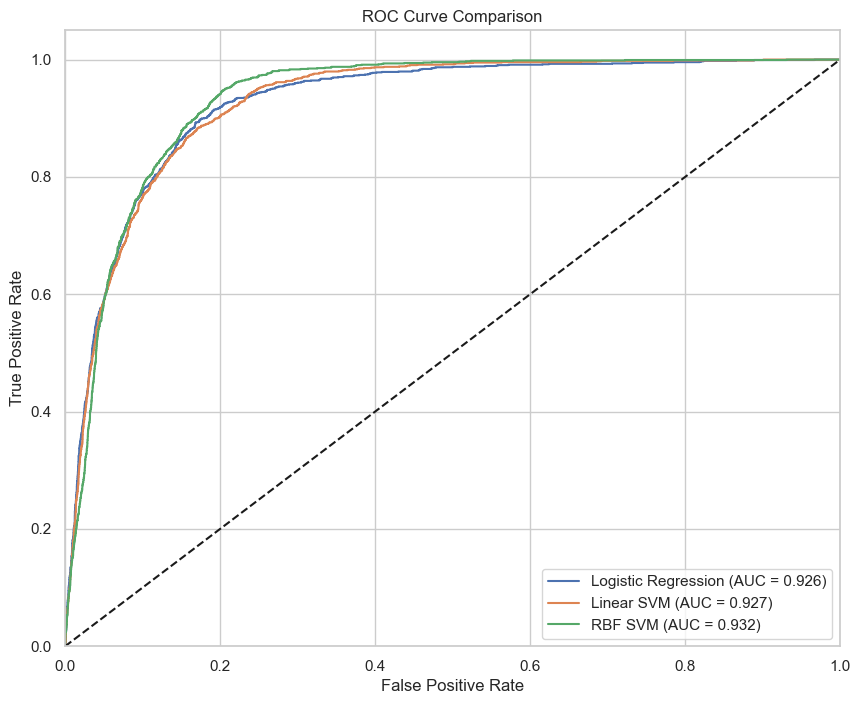


Best model: RBF SVM with F1 Score (Class 1) of 0.5848


In [66]:
# Part 2: Simplified SVM Implementation

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt

# Use the oversampled data for training
X_train = os_data_X
y_train = os_data_y['y']

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Select top 10 features instead of 15 (faster)
selector = SelectKBest(f_classif, k=10)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

selected_indices = selector.get_support(indices=True)
selected_features = X.columns[selected_indices]
print(f"Selected features: {selected_features.tolist()}")

# Only use the best two SVM variants (Linear and RBF)
# Linear SVM
svm_linear = SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
svm_linear.fit(X_train_selected, y_train)
y_pred_linear = svm_linear.predict(X_test_selected)

# RBF Kernel SVM with manually optimized parameters (skip grid search)
svm_rbf = SVC(kernel='rbf', C=10.0, gamma=0.1, class_weight='balanced', random_state=42, probability=True)
svm_rbf.fit(X_train_selected, y_train)
y_pred_rbf = svm_rbf.predict(X_test_selected)

# Evaluate and compare models
models = {
    "Logistic Regression": {"y_pred": y_pred},
    "Linear SVM": {"y_pred": y_pred_linear},
    "RBF SVM": {"y_pred": y_pred_rbf}
}

best_f1 = 0
best_model = ""

print("\n===== MODEL COMPARISON =====")
for model_name, model_data in models.items():
    accuracy = accuracy_score(y_test, model_data["y_pred"])
    report = classification_report(y_test, model_data["y_pred"], output_dict=True)
    f1_class_1 = report['1']['f1-score']
    
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Class 1): {f1_class_1:.4f}")
    print(classification_report(y_test, model_data["y_pred"]))
    
    conf_matrix = confusion_matrix(y_test, model_data["y_pred"])
    print("Confusion Matrix:")
    print(conf_matrix)
    
    if f1_class_1 > best_f1:
        best_f1 = f1_class_1
        best_model = model_name

# ROC curve comparison
plt.figure(figsize=(10, 8))
for model_name, model_info in models.items():
    if model_name == "Logistic Regression":
        y_prob = logreg.predict_proba(X_test)[:, 1]
    elif model_name == "Linear SVM":
        y_prob = svm_linear.predict_proba(X_test_selected)[:, 1]
    elif model_name == "RBF SVM":
        y_prob = svm_rbf.predict_proba(X_test_selected)[:, 1]
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"\nBest model: {best_model} with F1 Score (Class 1) of {best_f1:.4f}")


# Part 2: Use ANN, trying different topologies, hiperparameters and features to try to achieve a better result than the one obtained in Logistic Regression

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_selection import SelectKBest, f_classif
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

c:\bts\CDA\venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step
387/387 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step

===== MODEL COMPARISON =====

Logistic Regression:
Accuracy: 0.8563
F1 Score (Class 1): 0.5696
              precision    recall  f1-score   support

           0       0.98      0.86      0.91     10981
           1       0.43      0.85      0.57      1376

    accuracy                           0.86     12357
   macro avg       0.70      0.86      0.74     12357
weighted avg       0.92      0.86      0.88     12357

Confusion Matrix:
[[9406 1575]
 [ 201 1175]]

Simple ANN:
Accuracy: 0.8819
F1 Score (Class 1): 0.6123
              precision    recall  f1-score   support

           0       0.98      0.89      0.93     10981
           1       0.48      0.84      0.61      1376

    accuracy                           0.88     12357
   macro avg       0.73      0.86      0.77     12357
weighted avg       0.92      0.88      0.89     12357

Confusion Matrix:
[

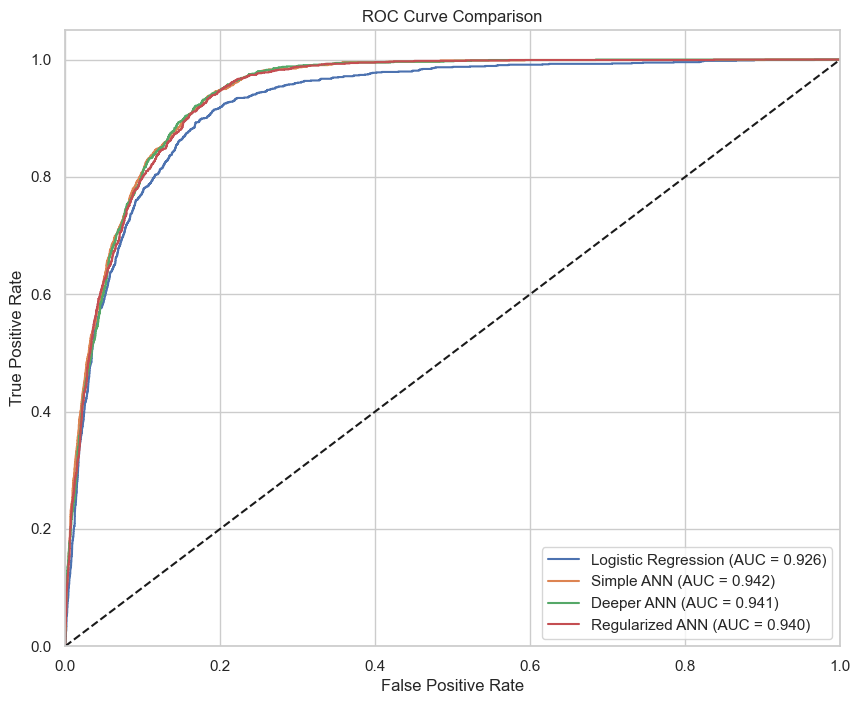


Best model: Simple ANN with F1 Score (Class 1) of 0.6123


In [65]:
X_train = os_data_X
y_train = os_data_y['y']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

selector = SelectKBest(f_classif, k=15)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
X_test_selected = selector.transform(X_test_scaled)

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Model 1: Simple ANN
model1 = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_selected.shape[1],)),
    Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history1 = model1.fit(X_train_selected, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2, callbacks=[early_stopping], verbose=0)
y_pred1 = (model1.predict(X_test_selected) > 0.5).astype(int)

# Model 2: Deeper ANN
model2 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_selected.shape[1],)),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history2 = model2.fit(X_train_selected, y_train, epochs=50, batch_size=32, 
                     validation_split=0.2, callbacks=[early_stopping], verbose=0)
y_pred2 = (model2.predict(X_test_selected) > 0.5).astype(int)

# Model 3: ANN with regularization
model3 = Sequential([
    Dense(32, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_selected.shape[1],)),
    Dropout(0.3),
    Dense(16, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(1, activation='sigmoid')
])
opt = Adam(learning_rate=0.001)
model3.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history3 = model3.fit(X_train_selected, y_train, epochs=100, batch_size=64, 
                     validation_split=0.2, callbacks=[early_stopping], verbose=0)
y_pred3 = (model3.predict(X_test_selected) > 0.5).astype(int)

# Evaluate models
models = {
    "Logistic Regression": {"y_pred": y_pred},
    "Simple ANN": {"y_pred": y_pred1.flatten()},
    "Deeper ANN": {"y_pred": y_pred2.flatten()},
    "Regularized ANN": {"y_pred": y_pred3.flatten()}
}

best_f1 = 0
best_model = ""

print("\n===== MODEL COMPARISON =====")
for model_name, model_data in models.items():
    accuracy = accuracy_score(y_test, model_data["y_pred"])
    report = classification_report(y_test, model_data["y_pred"], output_dict=True)
    f1_class_1 = report['1']['f1-score']
    
    print(f"\n{model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Class 1): {f1_class_1:.4f}")
    print(classification_report(y_test, model_data["y_pred"]))
    
    conf_matrix = confusion_matrix(y_test, model_data["y_pred"])
    print("Confusion Matrix:")
    print(conf_matrix)
    
    if f1_class_1 > best_f1:
        best_f1 = f1_class_1
        best_model = model_name

# ROC curve comparison
plt.figure(figsize=(10, 8))
for model_name, model_info in models.items():
    if model_name == "Logistic Regression":
        y_prob = logreg.predict_proba(X_test)[:, 1]
    elif model_name == "Simple ANN":
        y_prob = model1.predict(X_test_selected).flatten()
    elif model_name == "Deeper ANN":
        y_prob = model2.predict(X_test_selected).flatten()
    elif model_name == "Regularized ANN":
        y_prob = model3.predict(X_test_selected).flatten()
    
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc="lower right")
plt.show()

print(f"\nBest model: {best_model} with F1 Score (Class 1) of {best_f1:.4f}")